# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp
import astropy.constants as c

## Data

In [3]:
theoretical_values = [50, 0.70]
srate = 4096*4
t_range=np.arange(-1,1,1/srate)
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=theoretical_values[1])[0]
signal= 1e-22*np.real(np.exp(-1j*omega220*abs(t_range)/(theoretical_values[0]*T_MSUN))) \
        *1#np.heaviside(t_range, 1)

In [4]:
# pl.semilogy(t_range, np.abs(signal))
# pl.xlim(-0.05, 0.05)

## Filter

In [44]:
mass = qnm_filter.Filter.mass_unit(50)

In [45]:
data = signal
input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0+0*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096*4,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [46]:
padded_data = qnm_filter.RealData(signal, index=t_range)

fit.original_data['H1'] = padded_data
fit.detector_alignment()
# fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 3e-23**2
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()
fit.first_index()

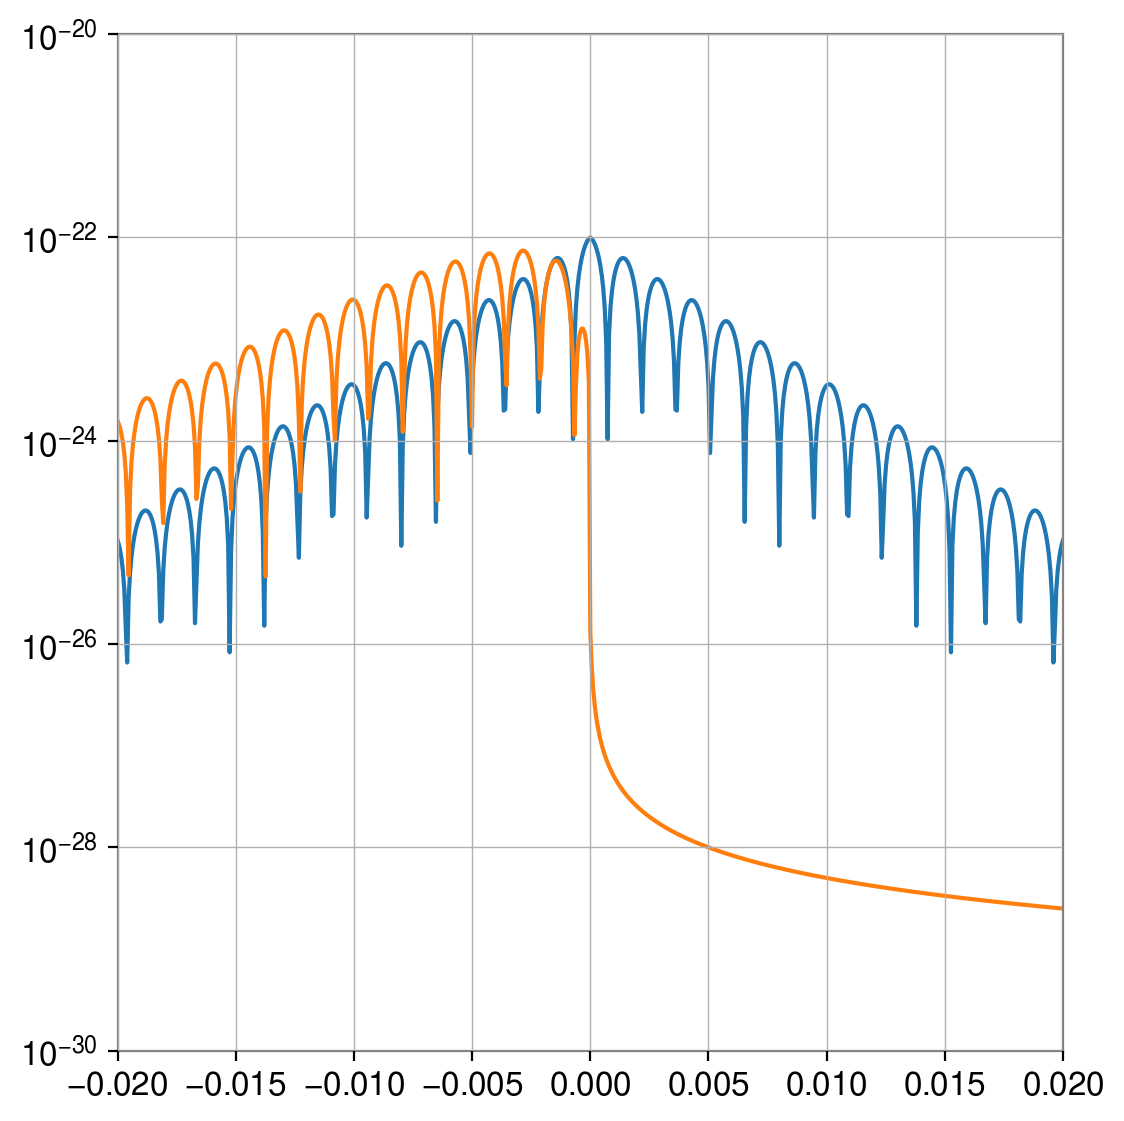

In [47]:
#Sanity check plots:

# fit.original_data['H1'].plot()
# pl.xlim(-0.02, 0.02)
# pl.show()

fit.add_filter(mass=50, chi=0.7, model_list=[(2,2,0,'p')])
pl.semilogy(fit.original_data['H1'].index, abs(fit.original_data['H1'].values))
pl.semilogy(fit.filtered_data['H1'].index, abs(fit.filtered_data['H1'].values))
pl.xlim(-0.02, 0.02)
pl.ylim(1e-30, 1e-20)
pl.show()

In [48]:
data = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, data, 'H1', optimal=True)
SNR

12.142534793228817

In [49]:
delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(10, 100, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [50]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.95)

In [55]:
nofilt_evidence = qnm_filter.evidence_parallel(fit,0,1,0,massspace, chispace, num_cpu=9, apply_filter = False)[1][0]

ln_BF = evidence - nofilt_evidence
occams = (np.count_nonzero(likelihood_data>credible_region)/len(mass_grid.flatten()))
FF = np.sqrt(1-(2/SNR**2)*(ln_BF-np.log(occams)))
FF

0.12867745854760648

In [59]:
likelihood=fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,2,0,'p')])
np.sqrt(1-2*likelihood/SNR**2)

1.0000000009380914

In [71]:
fit.compute_likelihood(apply_filter=False)

-73.72057560238619

In [72]:
likelihood=fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,2,0,'p')])
likelihood

-1.3831327344380777e-07

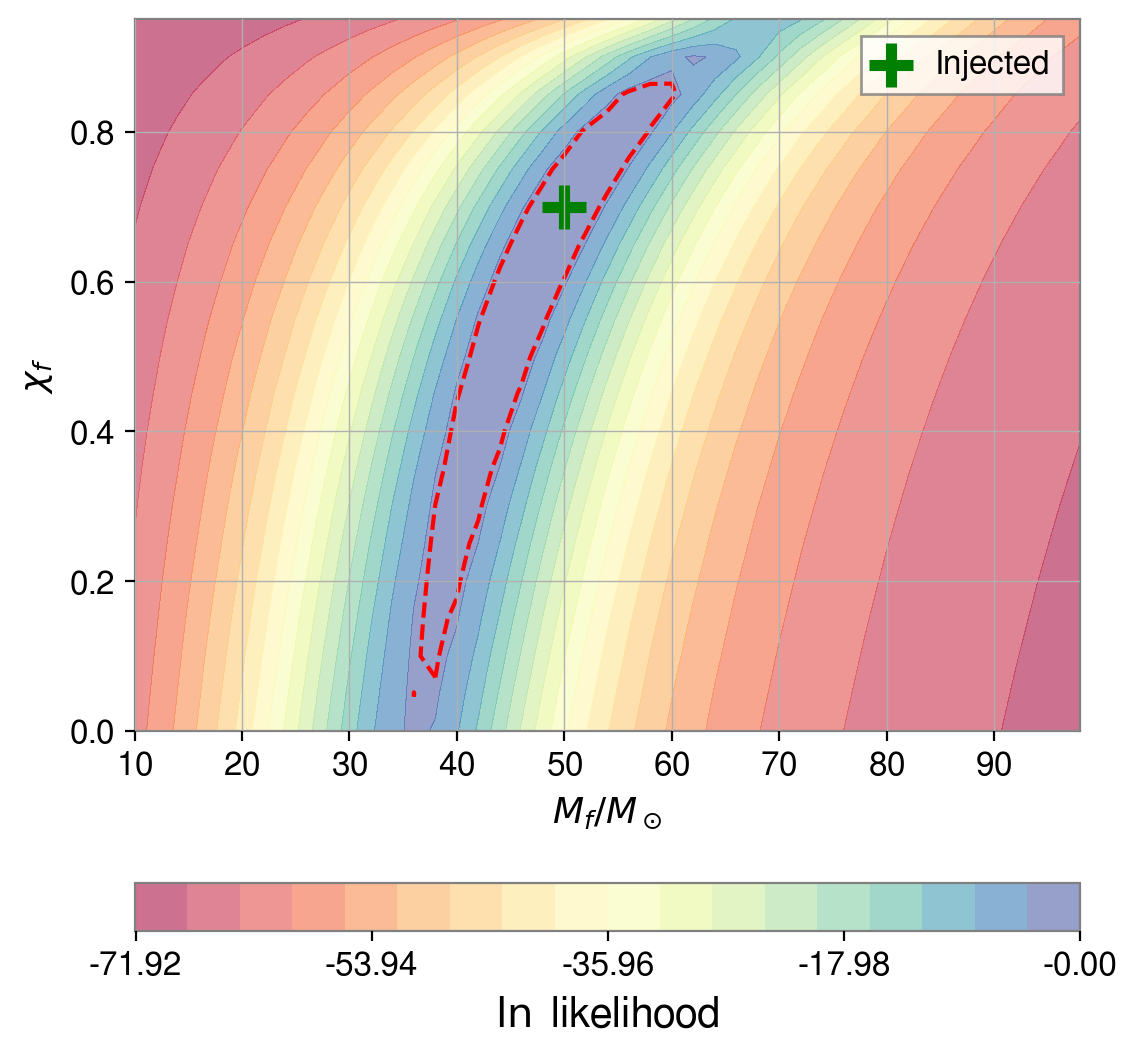

In [53]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
# ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
# ax.text(60, 0.1, 'ln(evidence) = %.2f' % (logsumexp(likelihood_data)))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))

## OF vs SNR

In [32]:
#Low resolution
snr_points = 30
scaling_arr = np.logspace(-0.5, 1, snr_points)

delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(10, 100, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

[lnBF_arr, occams_arr, SNR_arr, FF_arr] = [np.empty(snr_points) for i in range(4)]
time_offset = 0

for i, scale in enumerate(scaling_arr):
    data = signal + .5*noise
    input = dict(model_list = [(2,2,0, 'p')], #l, m, n
                 # trucation time (geocenter, in second)
                 t_init = 0.25+time_offset*mass, #Calculated from SNR+t_init notebook
                 # length of the analysis window (in second)
                 segment_length = 0.2,
                 # sampling rate after conditioning (in Hz)
                 srate = 4096,
                 # sky localization
                 ra = None, dec = None,
                 # lower limit of the high-pass filter (in Hz)
                 flow = 20)

    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = scale*1e-23**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, data, 'H1', optimal=True)
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    nofilt_evidence = qnm_filter.evidence_parallel(fit,0,1,0,massspace, chispace, num_cpu=9, apply_filter = False)[1][0]
    credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.95)

    ln_BF = evidence - nofilt_evidence
    occams = (np.count_nonzero(likelihood_data>credible_region)/len(mass_grid.flatten()))
    FF = np.sqrt(2/SNR**2*(ln_BF-np.log(occams)))
    
    lnBF_arr[i] = ln_BF
    occams_arr[i] = occams
    FF_arr[i] = FF
    SNR_arr[i] = SNR

In [33]:
occams_fit = np.polyfit(SNR_arr, np.log(occams_arr), deg=1)

Text(0.5, 1.0, 'Low resolution grid, $t_{init}$=0.25+0M')

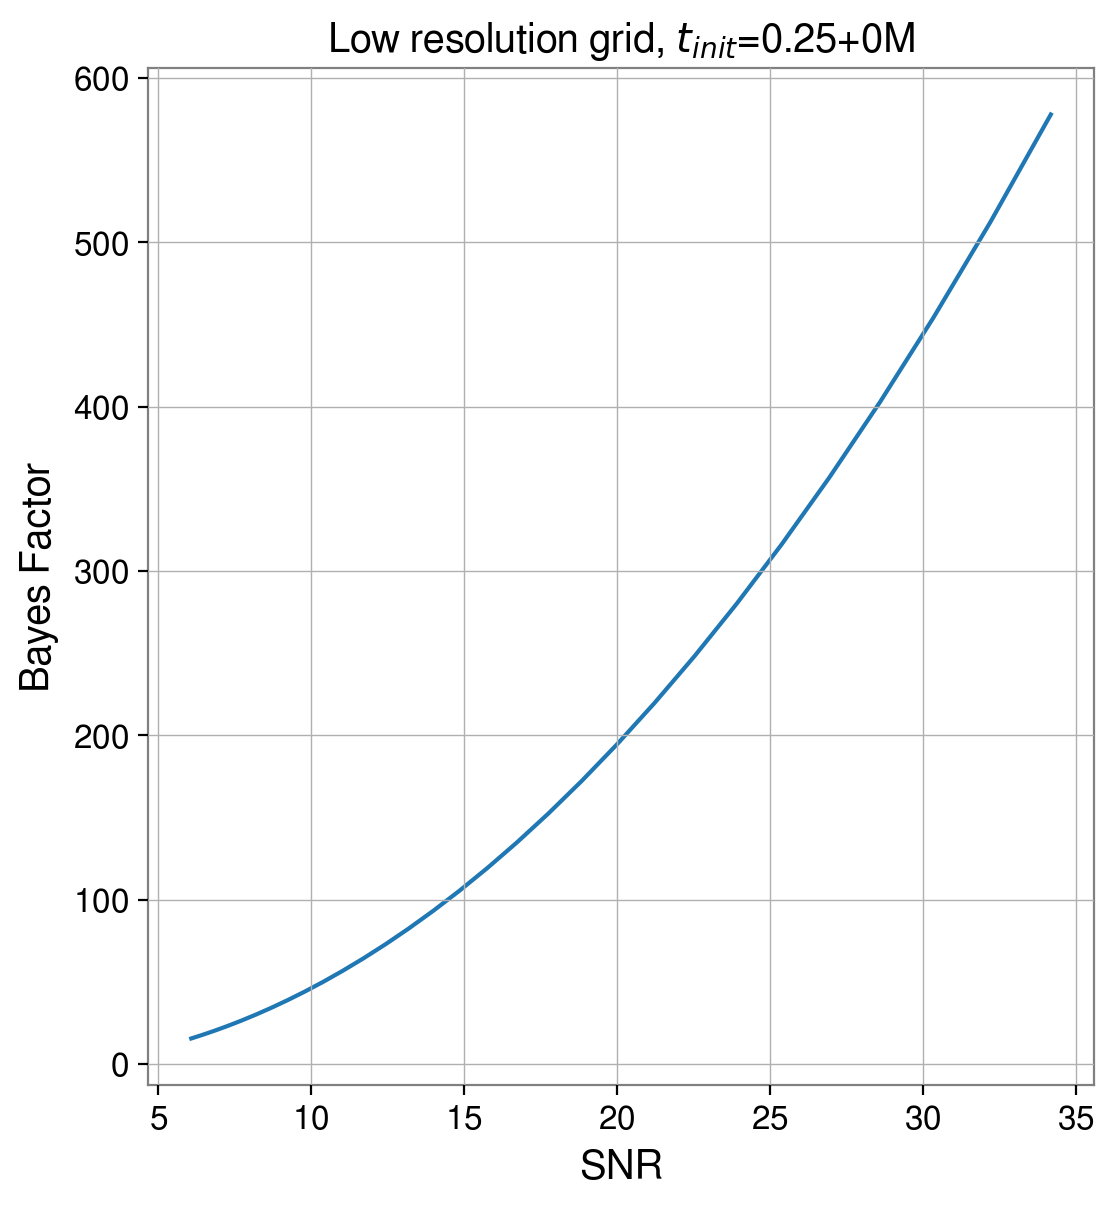

In [45]:
pl.plot(SNR_arr, -lnBF_arr)
# pl.plot(SNR_arr, occams_fit[0]*SNR_arr+occams_fit[1])
pl.xlabel("SNR")
pl.ylabel("Bayes Factor")
# pl.text(15.5, 0.08, r'ln($\mathcal{O}$)=%.2f $\times$ SNR %.2f' %(occams_fit[0], occams_fit[1]))
pl.title("Low resolution grid, $t_{init}$=0.25+%gM" % time_offset)

Text(0.5, 1.0, 'Low resolution grid, $t_{init}$=0.25+0M')

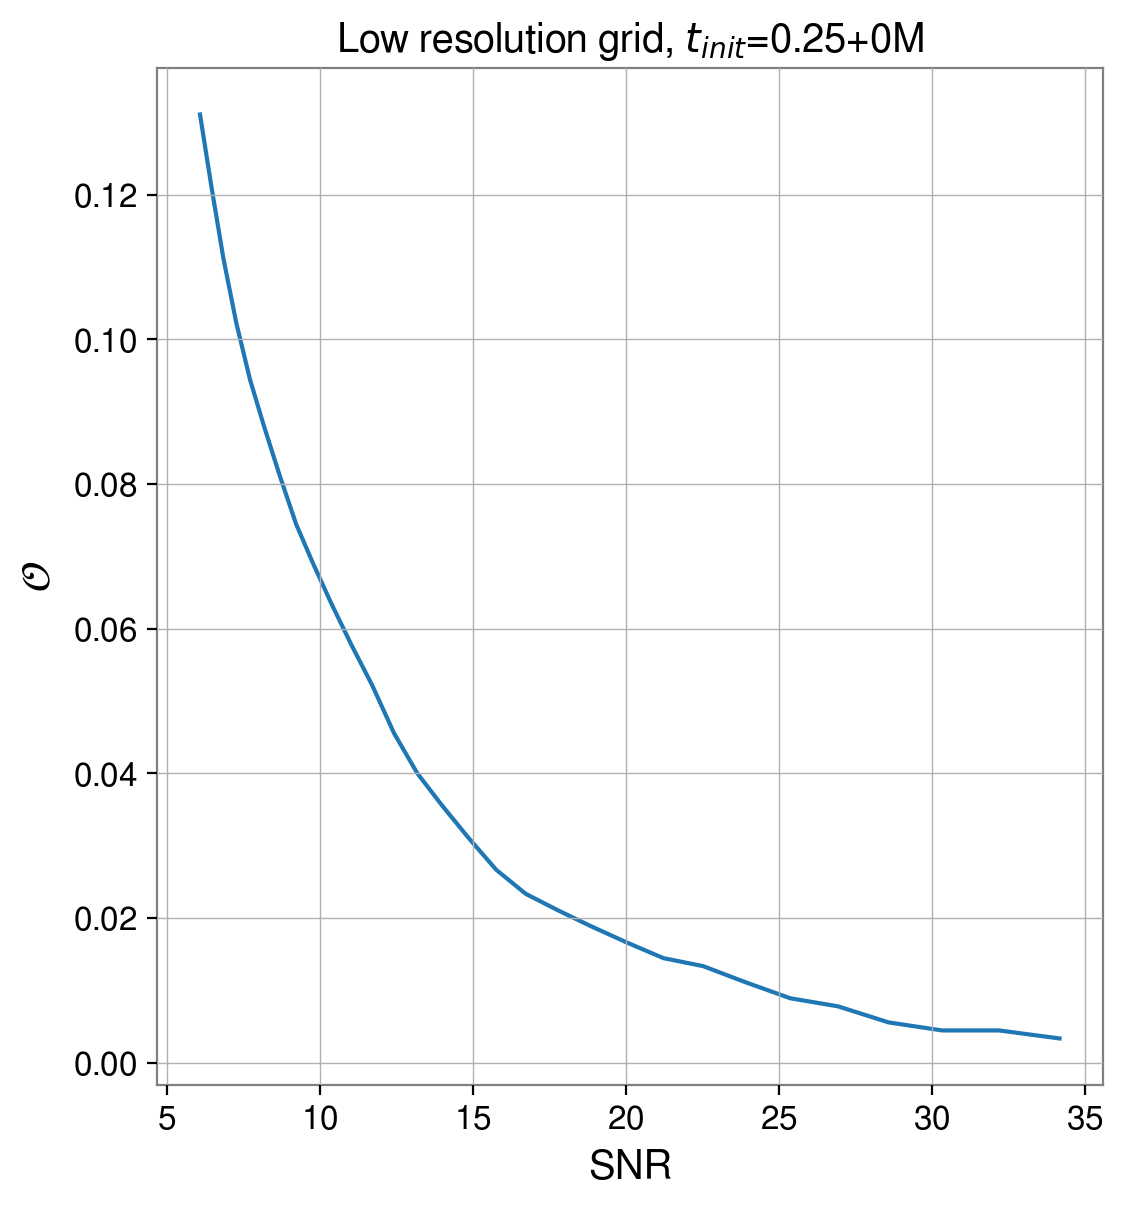

In [34]:
pl.plot(SNR_arr, occams_arr)
# pl.plot(SNR_arr, occams_fit[0]*SNR_arr+occams_fit[1])
pl.xlabel("SNR")
pl.ylabel("$\mathcal{O}$")
# pl.text(15.5, 0.08, r'ln($\mathcal{O}$)=%.2f $\times$ SNR %.2f' %(occams_fit[0], occams_fit[1]))
pl.title("Low resolution grid, $t_{init}$=0.25+%gM" % time_offset)

Text(0.5, 0, 'SNR')

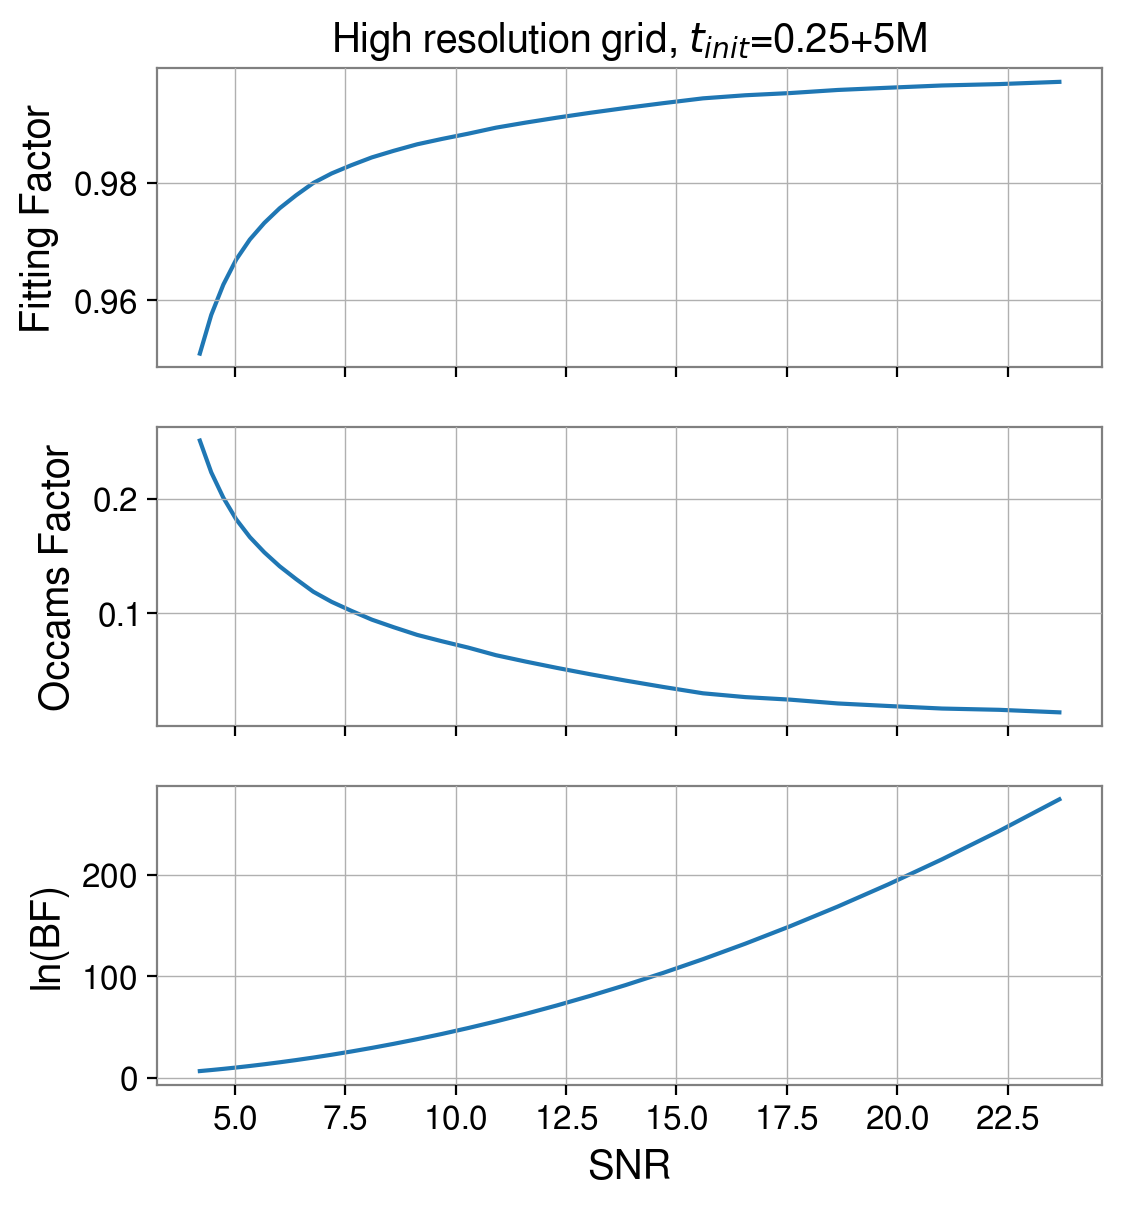

In [22]:
fig, axs = pl.subplots(3, sharex = True)
axs[0].plot(SNR_arr, FF_arr)
axs[0].set_ylabel('Fitting Factor')
axs[0].set_title("High resolution grid, $t_{init}$=0.25+%gM" % time_offset)

axs[1].plot(SNR_arr, occams_arr)
axs[1].set_ylabel("Occams Factor")

axs[2].plot(SNR_arr, lnBF_arr)
axs[2].set_ylabel("ln(BF)")
axs[2].set_xlabel("SNR")

In [35]:
[lnBF_hr, occams_hr, SNR_hr, FF_hr] = np.loadtxt("results/OF_vs_params_highRes_t=0M.txt")

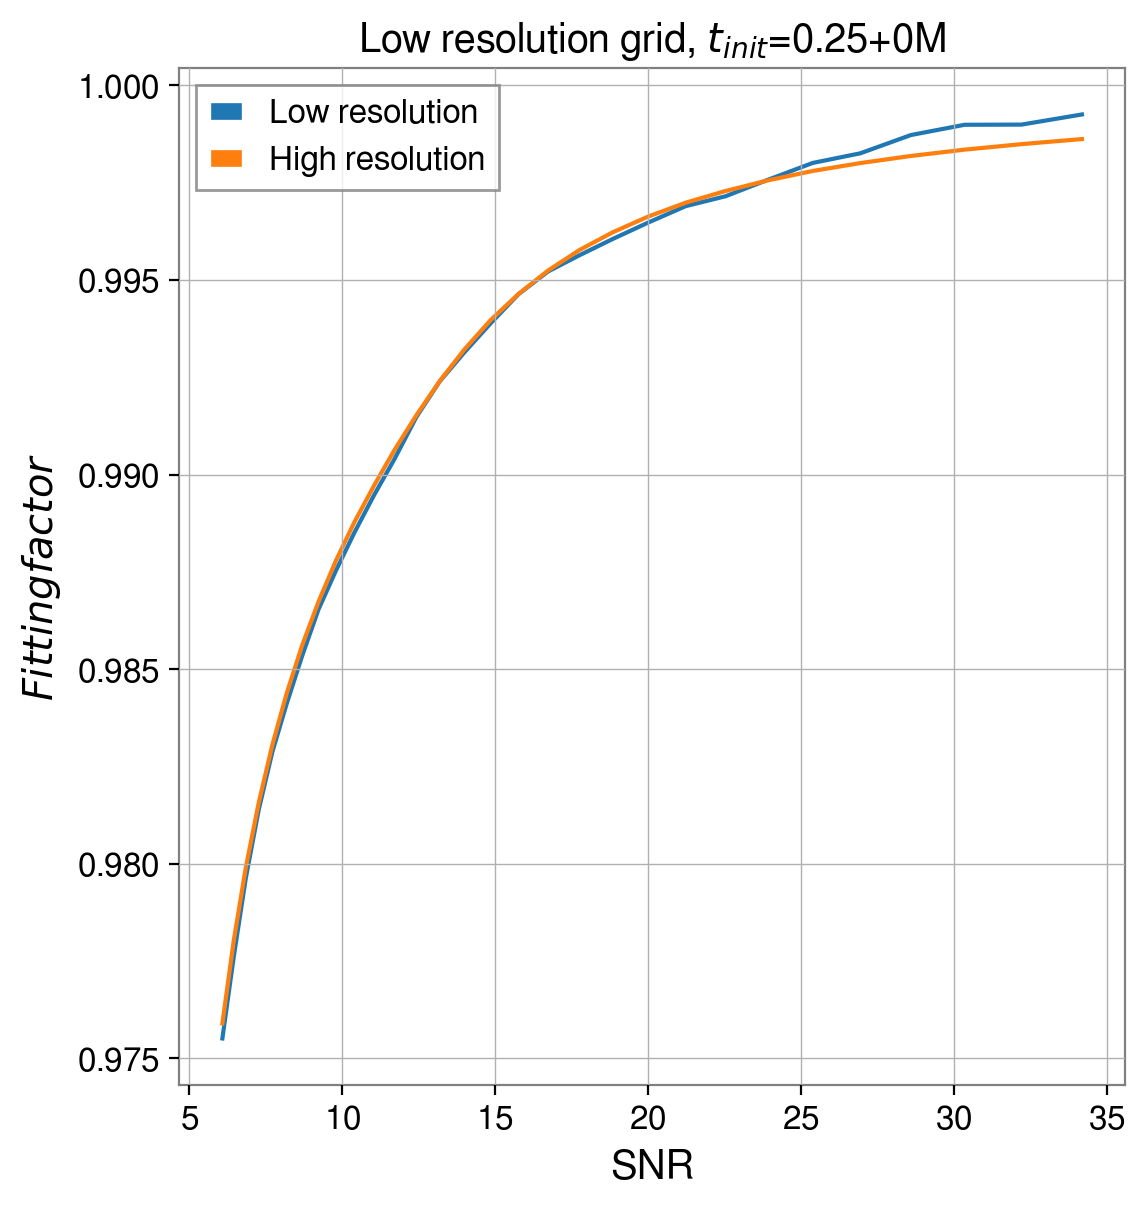

In [40]:
pl.plot(SNR_arr, FF_arr, label='Low resolution')
pl.plot(SNR_hr, FF_hr, label='High resolution')
pl.xlabel("SNR")
pl.ylabel("$Fitting factor$")
# pl.text(15.5, 0.08, r'ln($\mathcal{O}$)=%.2f $\times$ SNR %.2f' %(occams_fit[0], occams_fit[1]))
pl.title("Low resolution grid, $t_{init}$=0.25+%gM" % time_offset)
pl.legend()

In [59]:
fitted = np.polyfit(SNR_hr, lnBF_hr, deg=2)
fitted

array([ 0.50322477, -0.26530061, -1.53050244])

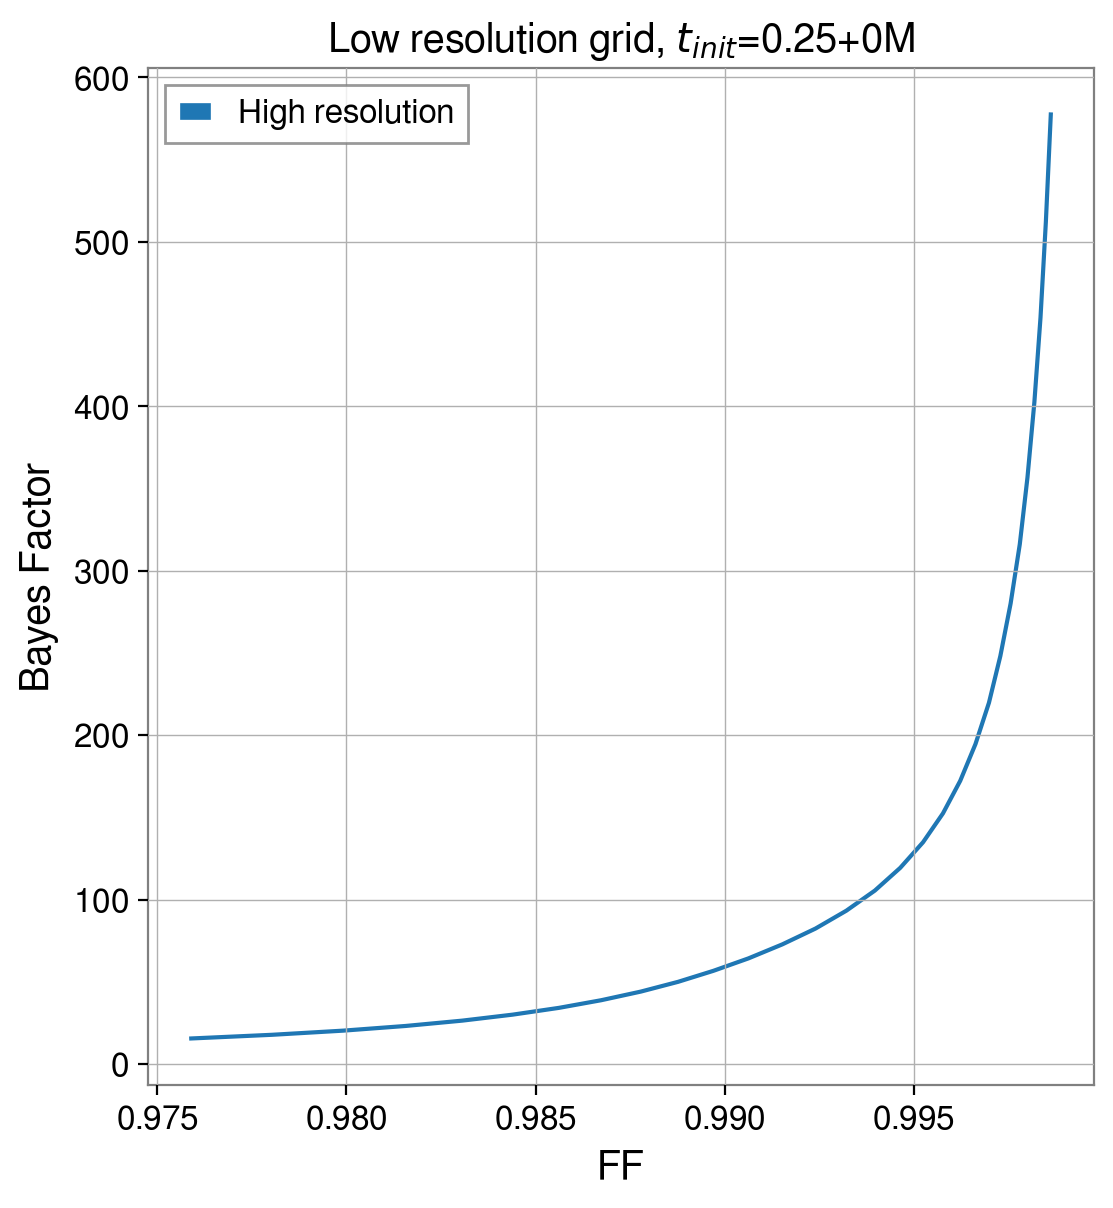

In [63]:
# pl.plot(1/SNR_arr, occams_arr, label='Low resolution')
pl.plot(FF_hr, lnBF_hr, label='High resolution')
# pl.plot(SNR_hr, fitted[0]*SNR_hr**2+fitted[1]*SNR_hr+fitted[2], label='Fitted')
pl.xlabel("FF")
pl.ylabel("Bayes Factor")
# pl.text(15.5, 0.08, r'ln($\mathcal{O}$)=%.2f $\times$ SNR %.2f' %(occams_fit[0], occams_fit[1]))
pl.title("Low resolution grid, $t_{init}$=0.25+%gM" % time_offset)
pl.legend()

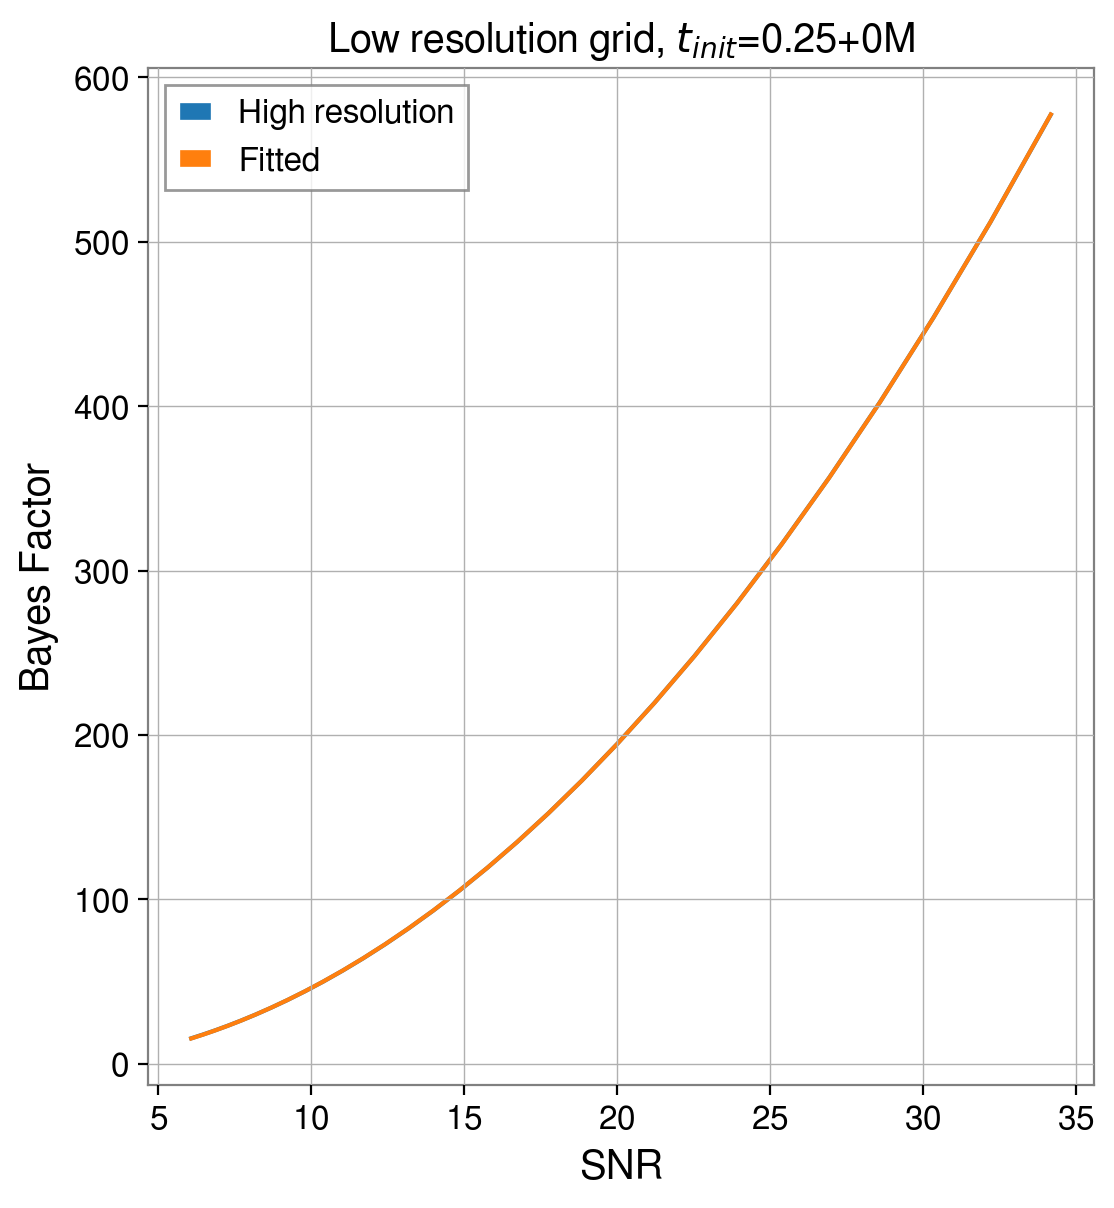

In [62]:
# pl.plot(1/SNR_arr, occams_arr, label='Low resolution')
pl.plot(SNR_hr, lnBF_hr, label='High resolution')
pl.plot(SNR_hr, fitted[0]*SNR_hr**2+fitted[1]*SNR_hr+fitted[2], label='Fitted')
pl.xlabel("SNR")
pl.ylabel("Bayes Factor")
# pl.text(15.5, 0.08, r'ln($\mathcal{O}$)=%.2f $\times$ SNR %.2f' %(occams_fit[0], occams_fit[1]))
pl.title("Low resolution grid, $t_{init}$=0.25+%gM" % time_offset)
pl.legend()

In [ ]:
fitted = np.polyfit(1/SNR_arr, occams_hr, deg=2)
fitted

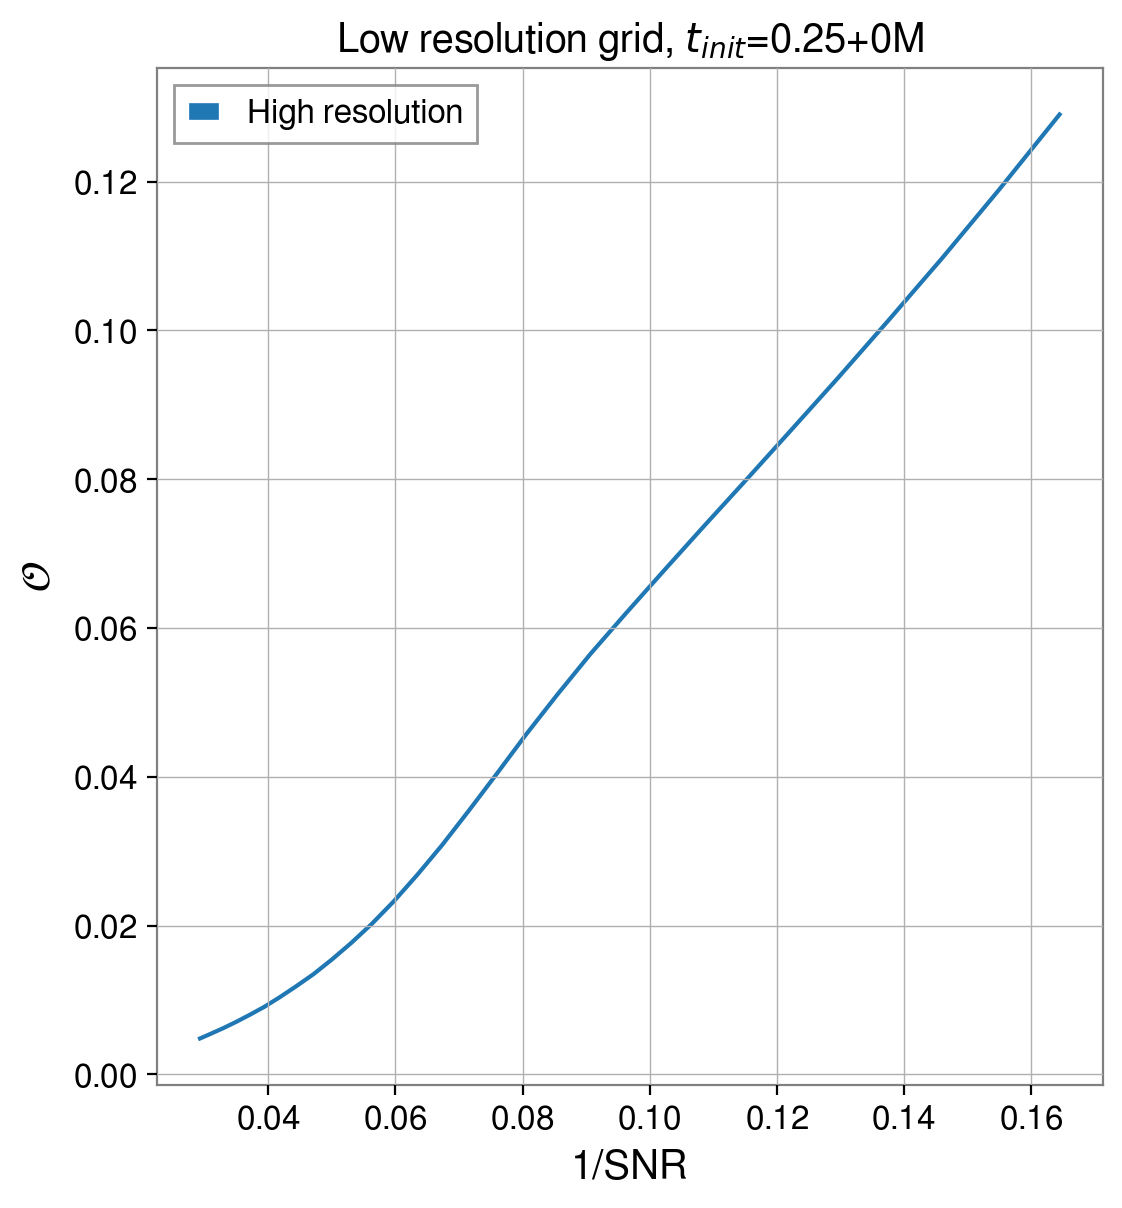

In [54]:
# pl.plot(1/SNR_arr, occams_arr, label='Low resolution')
pl.plot(1/SNR_hr, occams_hr, label='High resolution')
# pl.plot(1/SNR_hr, fitted[0]*(1/SNR_hr)**2+fitted[1]*(1/SNR_hr)+fitted[2], label='Fitted')
pl.xlabel("1/SNR")
pl.ylabel("$\mathcal{O}$")
# pl.text(15.5, 0.08, r'ln($\mathcal{O}$)=%.2f $\times$ SNR %.2f' %(occams_fit[0], occams_fit[1]))
pl.title("Low resolution grid, $t_{init}$=0.25+%gM" % time_offset)
pl.legend()

In [ ]:
# np.savetxt("results/OF_vs_params_highRes_t=5M.txt", [lnBF_arr, occams_arr, SNR_arr, FF_arr])

In [ ]:
np.polyfit(np.log(SNR_arr), np.log(lnBF_arr), deg=1)

## Assume FF=1

In [39]:
snr_points = 30
scaling_arr = np.logspace(-0.5, 1, snr_points)

delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(10, 100, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

[lnBF_fixed, lnOccams_fixed, SNR_fixed] = [np.empty(snr_points) for i in range(3)]
time_offset = 0

for i, scale in enumerate(scaling_arr):
    data = signal + .5*noise
    input = dict(model_list = [(2,2,0, 'p')], #l, m, n
                 # trucation time (geocenter, in second)
                 t_init = 0.25+time_offset*mass, #Calculated from SNR+t_init notebook
                 # length of the analysis window (in second)
                 segment_length = 0.2,
                 # sampling rate after conditioning (in Hz)
                 srate = 4096,
                 # sky localization
                 ra = None, dec = None,
                 # lower limit of the high-pass filter (in Hz)
                 flow = 20)

    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = scale*1e-23**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, data, 'H1', optimal=True)
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    nofilt_evidence = qnm_filter.evidence_parallel(fit,0,1,0,massspace, chispace, num_cpu=9, apply_filter = False)[1][0]
    credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.95)

    ln_BF = evidence - nofilt_evidence
    ln_occams = ln_BF-SNR**2/2
    
    lnBF_fixed[i] = ln_BF
    lnOccams_fixed[i] = ln_occams
    SNR_fixed[i] = SNR

Text(0.5, 1.0, 'Fixing FF=1: Low resolution grid, $t_{init}$=0.25+0M')

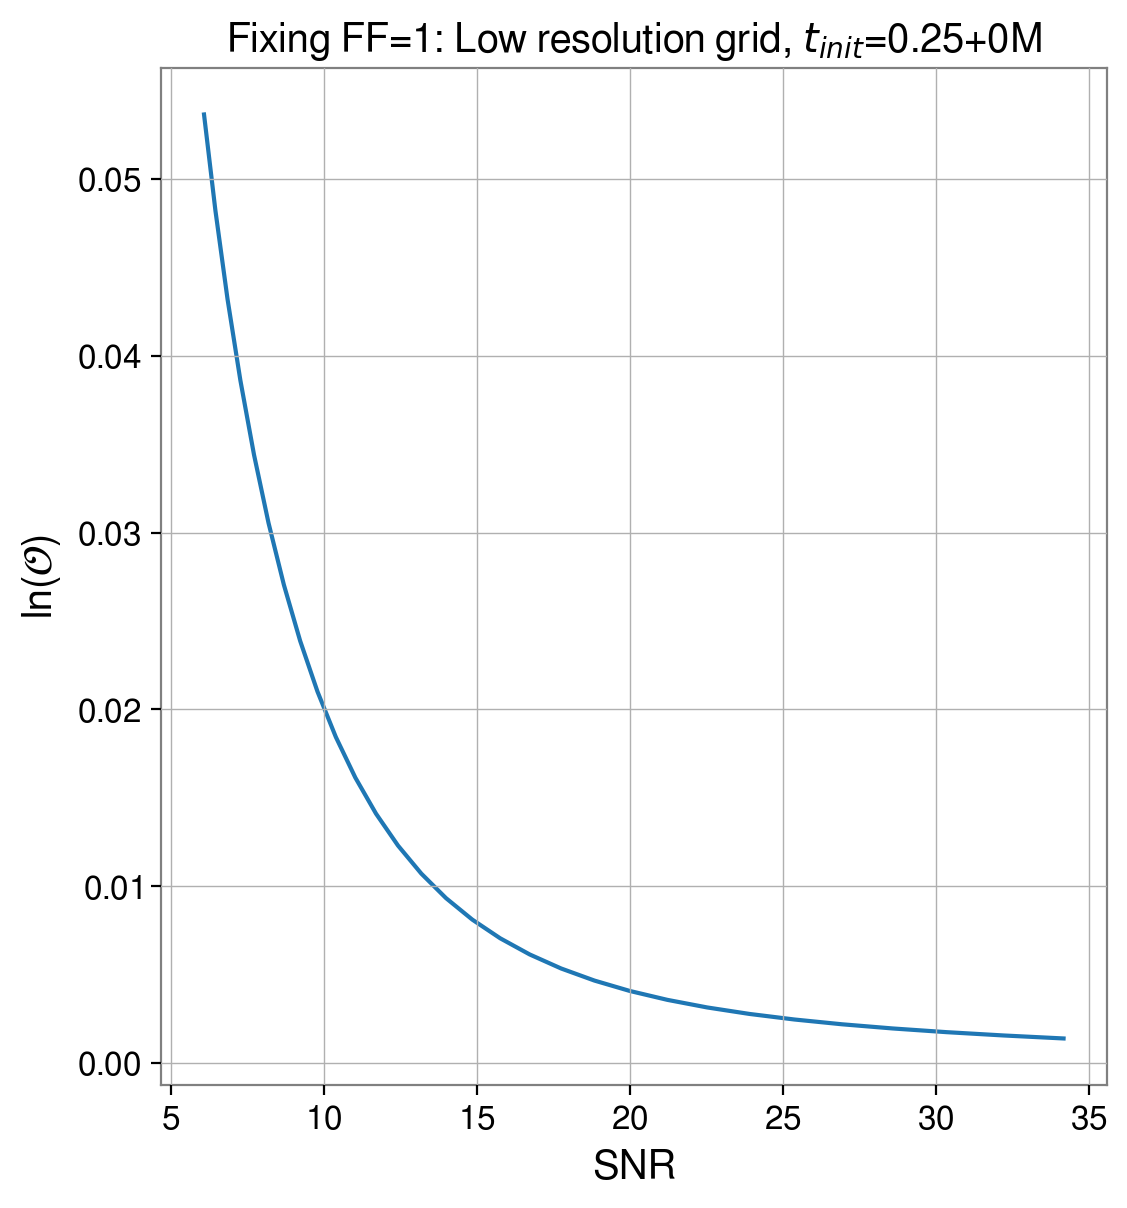

In [42]:
pl.plot(SNR_fixed, np.exp(lnOccams_fixed))
# pl.plot(SNR_arr, occams_fit[0]*SNR_arr+occams_fit[1])
pl.xlabel("SNR")
pl.ylabel("ln($\mathcal{O}$)")
# pl.text(15.5, -2.2, r'ln($\mathcal{O}$)=%.2f $\times$ SNR %.2f' %(occams_fit[0], occams_fit[1]))
pl.title("Fixing FF=1: Low resolution grid, $t_{init}$=0.25+%gM" % time_offset)

## Likelihood Ratio

In [ ]:
import scipy

def theoretical(SNR, FF, logO):
    return (1-FF**2)*SNR**2/2+logO

In [ ]:
snr_points = 30
scaling_arr = np.logspace(-2, 0.8, snr_points)

massspace = np.arange(30, 80, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)

noise = 0*np.random.normal(size = srate)
SNR_arr = []
bayes_arr = []
for j in scaling_arr:
    data = j*signal + noise

    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = 1e-23**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    data = fit.truncate_data(fit.original_data)['H1']

    SNR = fit.compute_SNR(None, data, 'H1', optimal=True)
    fit.compute_likelihood(apply_filter = False)
    fit.add_filter(mass = theoretical_values[0], chi = theoretical_values[1], model_list = [(2,2,0,'p')])
    Bayes = fit.compute_likelihood() - fit.compute_likelihood(apply_filter=False)

    SNR_arr.append(SNR)
    bayes_arr.append(Bayes)

In [ ]:
# test = fit.truncate_data(fit.filtered_data)['H1']
# (fit.compute_SNR(None, test, 'H1', optimal=True) - SNR)/SNR

In [ ]:
fitting = np.polyfit(np.log10(SNR_arr), np.log10(bayes_arr), deg=1)
fitting

In [ ]:
np.log10(0.5)

In [ ]:
FF = np.sqrt(2*np.power(10,fitting[1]))

In [ ]:
pl.loglog(SNR_arr, bayes_arr)
pl.title("Pointwise: $M_{filt} = 1000M_{inj}, \chi_{filt}=\chi_{inj}-0.7$")
pl.xlabel("log(SNR)")
pl.ylabel(r'log$^2$(Likelihood ratio)')
pl.text(13, 3e-5, 'Slope = %.1f \nIntercept = %.2f \nFF=%.2f' % (fitting[0], fitting[1], FF))

In [ ]:
pl.plot(SNR_arr, bayes_arr)
pl.xlabel("SNR")
pl.ylabel(r'log(BF)')

In [ ]:
theoretical_fit = scipy.optimize.curve_fit(theoretical, SNR_arr, bayes_arr)
print(theoretical_fit[0])
print(np.log10((1-theoretical_fit[0][0]**2)/2))

## Evidence

In [ ]:
delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(30, 80, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [ ]:
snr_points = 20
scaling_arr = np.logspace(-2, 0.8, snr_points)

noise = 0*np.random.normal(size = srate)
SNR_arr = []
bayes_arr = []
for j in scaling_arr:
    data = signal + j*noise

    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = j*1e-23**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    data = fit.truncate_data(fit.original_data)['H1']

    SNR = fit.compute_SNR(None, data, 'H1', optimal=True)
    filt_evidence = qnm_filter.evidence_parallel(fit,0,1,0,massspace, chispace, 
                         num_cpu=9, apply_filter = True,**input)
    nofilt_evidence = qnm_filter.evidence_parallel(fit,0,1,0,massspace, chispace, num_cpu=9, apply_filter = False)
    Bayes = filt_evidence[1][0] - nofilt_evidence[1][0]

    SNR_arr.append(SNR)
    bayes_arr.append(Bayes)

In [ ]:
pl.loglog(SNR_arr, bayes_arr)
pl.xlabel("log(SNR)")
pl.ylabel(r'log$^2$(BF)')

In [ ]:
np.polyfit(np.log10(SNR_arr), np.log10(bayes_arr), deg=1)

In [ ]:
pl.plot(SNR_arr, bayes_arr)
pl.xlabel("SNR")
pl.ylabel(r'log(BF)')

In [ ]:
theoretical_fit = scipy.optimize.curve_fit(theoretical, SNR_arr, bayes_arr)
theoretical_fit

In [ ]:
np.log10((1-theoretical_fit[0][0]**2)/2)

## Occam's factor vs SNR

In [ ]:
def occams_calc(SNR_scale):
    data = signal + .5*noise
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = SNR_scale*1e-23**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, data, 'H1', optimal=True)
    delta_mass = 1.0
    delta_chi = 0.03
    massspace = np.arange(30, 80, delta_mass)
    chispace = np.arange(0.0, 0.99, delta_chi)
    mass_grid, chi_grid = np.meshgrid(massspace, chispace)
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    credible_region = qnm_filter.find_credible_region(likelihood_data)
    nofilt_evidence = qnm_filter.evidence_parallel(fit,0,1,0,massspace, chispace, num_cpu=9, apply_filter = False)[1][0]

    ln_BF = evidence - nofilt_evidence
    occams = (np.count_nonzero(likelihood_data>credible_region)/len(mass_grid.flatten()))
    return occams, SNR

In [ ]:
snr_points = 30
scaling_arr = np.logspace(-1, 0.8, snr_points)

occams_arr = []
SNR_arr = []
for i in scaling_arr:
    occams, SNR = occams_calc(i)
    occams_arr.append(occams)
    SNR_arr.append(SNR)

In [ ]:
fitting = np.polyfit(np.log10(SNR_arr), np.log10(occams_arr), deg=1)
fitting

In [ ]:
SNR_arr = np.array(SNR_arr)
occams_arr = np.array(occams_arr)

In [ ]:
temp_SNR = np.log10(SNR_arr)
temp_occams = np.log10(occams_arr)
pl.plot(temp_SNR, temp_occams)
pl.plot(temp_SNR, fitting[0]*temp_SNR+fitting[1])